# Traffic Camera: Detection and IOU tracking


## Imports

We will start by importing a few libraries:

In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Tue Sep  3 07:46:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from os.path import join
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
os.chdir("/gdrive/My Drive/Colab Notebooks/TrafficAnalysis-master/")

In [0]:
#%load IOUTracker.py

In [0]:
!pip install -q pascal-voc-writer

In [6]:
import matplotlib.pyplot as plt
from detectionprovider import DetectionProvider
from common import limit_gpu_memory, Detection
from IOUTracker import IOUTracker
from video import VideoStreamReader, VideoStreamWriter
from yolo import YOLO
from tqdm import tqdm_notebook
import numpy as np
limit_gpu_memory(0.7)
import cv2
from pascal_voc_writer import Writer as LabelWriter
import csv
import time
from datetime import datetime
import pandas as pd

Using TensorFlow backend.
W0903 07:47:06.478401 140579611662208 deprecation_wrapper.py:119] From /gdrive/My Drive/Colab Notebooks/TrafficAnalysis-master/common.py:43: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0903 07:47:06.480268 140579611662208 deprecation_wrapper.py:119] From /gdrive/My Drive/Colab Notebooks/TrafficAnalysis-master/common.py:45: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
from shapely.geometry import LineString

## Download 4K Traffic Cam Video

You will need **youtube-dl** to download the video. (You can ignore this step but still, you will need a video

In [0]:
!pip install --upgrade youtube_dl

    100% |████████████████████████████████| 1.8MB 15.7MB/s 


In [0]:
!youtube-dl -f 313 MNn9qKG2UFI

[youtube] MNn9qKG2UFI: Downloading webpage
[youtube] MNn9qKG2UFI: Downloading video info webpage
[download] 4K Traffic camera video - free download now!-MNn9qKG2UFI.webm has already been downloaded
[download] 100% of 656.19MiB


## View first frame

We will use OpenCV and Matplotlib to view the very first frame:

In [0]:
class ROI_Count:
    def __init__(self, x1, y1, x2, y2, color=(255,0,0), width=3):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.color = color
        self.width = width

    def showROI(self, frame):
        cv2.line(frame, (self.x1, self.y2), (self.x2, self.y2), self.color, self.width)

In [0]:
line1 = ROI_Count(350,510,750,510)

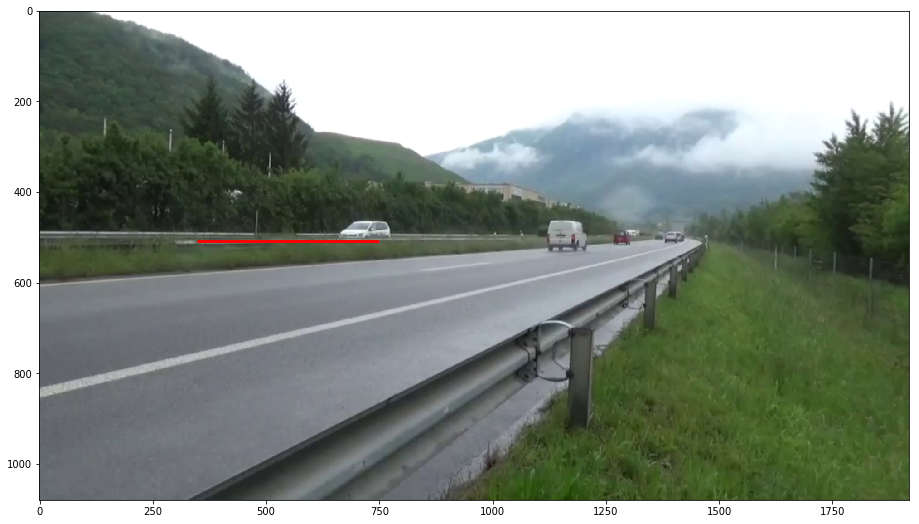

True

In [0]:
filename = "Astra1.mp4"

reader = VideoStreamReader(filename, seconds_count=5, width=1920, height=1080)
frame = reader.next_frame()
reader.release()
line1.showROI(frame)
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()


frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
cv2.imwrite("base.png", frame )

In [0]:
# input video
#video_in = 'long'
#cap = cv2.VideoCapture(video_in)

# Prepare YOLO network

In [8]:
yolo = YOLO(score=0.7)

W0903 07:47:42.720488 140579611662208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 07:47:42.722169 140579611662208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0903 07:47:43.374068 140579611662208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 07:47:45.560126 140579611662208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0903 07:47:5

model_data/yolo.h5 model, anchors, and classes loaded.


W0903 07:48:02.591480 140579611662208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Show detections for the first frame

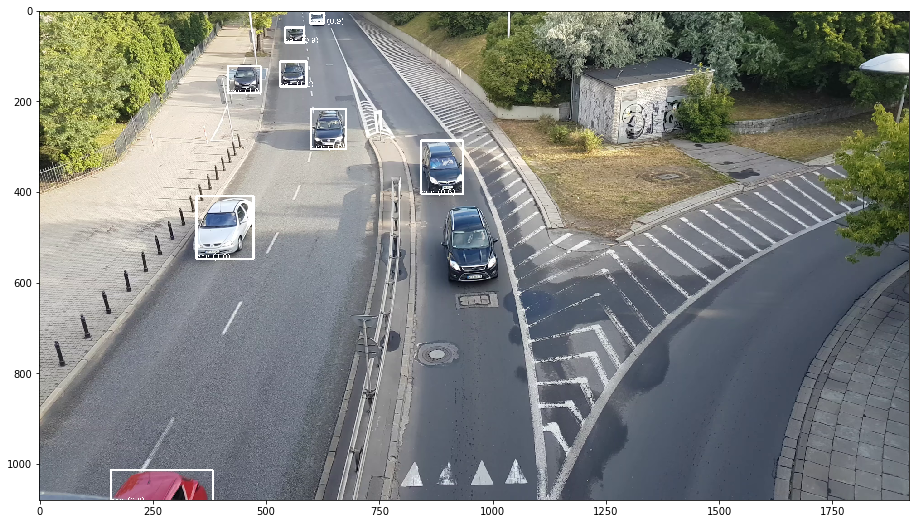

True

In [0]:
#import cv2

detection_provider = DetectionProvider(yolo)
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"

reader = VideoStreamReader(filename, seconds_count=5, width=1920, height=1080)
frame = reader.next_frame()
detections = detection_provider.detect_boxes(frame, reader.frame_no)


for detection in detections:
        detection.show(frame, (255, 255, 255), width=4)
        
#line1.showROI(frame)
reader.release()
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
cv2.imwrite("detection.png", frame )

In [0]:
timeInit = 1
vTime = reader.capture.get(cv2.CAP_PROP_POS_MSEC)/1000+timeInit

In [0]:
vTime


1.0

In [0]:
starttime

Timestamp('2016-10-05 11:53:16')

In [0]:
starttime + pd.Timedelta(seconds=vTime)

Timestamp('2016-10-05 11:53:17')

In [0]:
tTime

'11:53:15'

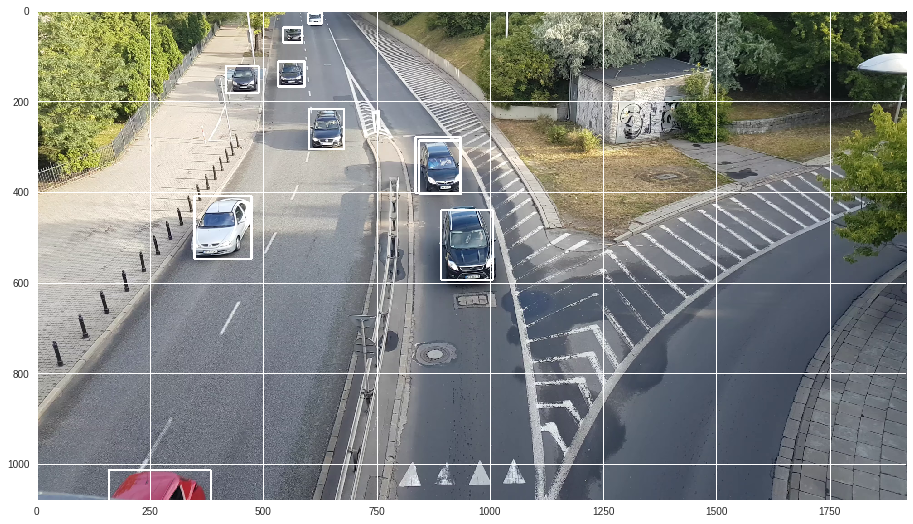

True

In [0]:
#import cv2

detection_provider = DetectionProvider(yolo)
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"

reader = VideoStreamReader(filename, seconds_count=5, width=1920, height=1080)
frame = reader.next_frame()
detections = detection_provider.detect_boxes(frame, reader.frame_no)
for detection in detections:
        detection.show(frame, (255, 255, 255), width=4)

reader.release()
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
cv2.imwrite("detection.png", frame )

# Load frames and propagate through them

In [0]:
class ROI_Count:
    def __init__(self, line, color=(255,0,0), width=3):
        self.x1 = line[0][0]
        self.y1 = line[0][1]
        self.x2 = line[1][0]
        self.y2 = line[1][1]
        self.color = color
        self.width = width

    def showROI(self, frame):
        cv2.line(frame, (self.x1, self.y1), (self.x2, self.y2), self.color, self.width)

In [0]:
def showROI(frame, line):
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[1][0]
    y2 = line[1][1]
    color = (255,0,0)
    width = 3
    cv2.line(frame, (x1, y1), (x2, y2), color, width)

In [0]:
file = 'Vehicles_2016-05-10.csv'
df = pd.read_csv(file)
df['Start'] = pd.to_datetime(df["Start-Timestamp"])
df['End'] = pd.to_datetime(df["End-Timestamp"])
startTime = pd.to_datetime('10.05.2016 11:53:16')
df_new = df[df['Start'] >= startTime] 
df_new.reset_index(inplace=True)
#pd.Timedelta(df_new['Start'][2]-startTime).seconds

In [12]:
filename = "Astra1.mp4"
#filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"
seconds_skip = 0 # number of seconds to skip
seconds_count = 20 # number of seconds to process

vidreader = VideoStreamReader(filename, seconds_count=seconds_count, seconds_skip=seconds_skip, width=1920, height=1080)
vidwriter = VideoStreamWriter("Astra-07_ROI.avi", width=vidreader.width,height=vidreader.height,fps=vidreader.fps)
#empty_writer = VideoStreamWriter("out_black_short.avi", width=vidreader.width,height=vidreader.height,fps=vidreader.fps)
detection_provider = DetectionProvider(yolo)

#define the detection zone??
padding=0
frame_bbox = Detection.from_frame((vidreader.width,vidreader.height), int(padding))

tracker = IOUTracker()
imgCount = 0
imgPath = 'output-roi/'

timeInit = 42795.100

XY=[]
XY_finder = False
csv_writer = True
capByDetect = True
capByFrame = False
buzzerOnFrame = False
buzzOnDetect = False
videoShowROI = True
#LOI1 = [(750,400), (750,800)]
#LOI2 = [(450,700), (450,800)]
LOIs = [[(750,400), (750,800)]]
line1 = LineString(LOIs[0])
#line2 = LineString(LOIs[1])

vehicleInVid = 1

lanePoints=[]
direction = None
Dcounter = 0
#vectors = []

# initialize .csv
if csv_writer:
    with open('traffic_measurement-roi.csv', 'w+') as f:
        writer = csv.writer(f)
        csv_line = 'timestamp, lane, vehicle, direction'
        writer.writerows([csv_line.split(',')])

#nice progress bar:
pbar = tqdm_notebook(total=vidreader.frame_count - vidreader.frame_skip)

while True:
    frame = vidreader.next_frame()
    
    if frame is None:
        break
    frame_copy = frame.copy()
        
    pbar.update()
     
    if capByFrame:
        if vidreader.frame_no % vidreader.fps == 0:
            buzzerOnFrame = True
            imgCount += 1
            imgName = "img%s" % (imgCount)
            filepathname = os.path.join(imgPath, imgName)
            cv2.imwrite(filepathname + ".jpg", cv2.cvtColor(frame_copy, cv2.COLOR_RGB2BGR))
            labelwriter = LabelWriter(filepathname, vidreader.width, vidreader.height)
        else:
            buzzerOnFrame = False
            
    
    detections = detection_provider.detect_boxes(frame, vidreader.frame_no)
        
    tracker.predict()
    tracker.update(detections, frame_bbox)

    #zero_frame = np.zeros_like(frame)
    
    for track in tracker.active_tracks:
        track.likely_class()
        track.lane_detector()
        if (track.counted is False) and track.is_confirmed() and track.res != "car" and track.lane != 2:
            for count_line in LOIs:
                detected, vector = track.intersection_detection(count_line)
                if detected:
                    Dcounter += 1
                    #vectors.append(vector)
                    #print("Detection!")
                    if capByDetect:
                        dbox = track.detections[-1].to_tlbr()
                        imgName = "img%s" % (Dcounter)
                        filepathname = os.path.join(imgPath, imgName)
                        if track.res is not None:
                            classres = track.res
                        else:
                            classres = track.detections[-1].object_class

                        bx1 = track.detections[-1].to_tlbr()[0]
                        by1 = track.detections[-1].to_tlbr()[1]
                        bx2 = track.detections[-1].to_tlbr()[2]
                        by2 = track.detections[-1].to_tlbr()[3]                        

                        cv2.imwrite(filepathname + ".jpg", cv2.cvtColor(frame_copy, cv2.COLOR_RGB2BGR))                        
                        
                        vTime = vidreader.capture.get(cv2.CAP_PROP_POS_MSEC)/1000
                        nowTime = startTime + pd.Timedelta(seconds=vTime) - pd.Timedelta(seconds=vehicleInVid)
                        matchingRows = df_new.loc[df_new['Start'].dt.floor('S') == nowTime.floor('S')]
                        if not matchingRows.empty:
                            probVeh = matchingRows['ExtCatText']
                            for vItem in probVeh.iteritems():
                                if (vItem[1]) != "Car":
                                    track.res = (vItem[1])
                           # track.ovrVeh = probVeh.item()
                        
                        labelwriter = LabelWriter(filepathname, vidreader.width, vidreader.height) 
                        labelwriter.addObject(classres, bx1,by1,bx2,by2)
                        labelwriter.save(filepathname + ".xml")                                                                 
           
                    csv_line = str(nowTime) + "," + str(track.lane) + "," + str(track.res) + "," + str(track.direction)
                    with open('traffic_measurement-roi.csv', 'a') as f:
                        writer = csv.writer(f)
                        (timestamp, lane, vehicle, direction) = csv_line.split(',')
                        writer.writerows([csv_line.split(',')])
              
                
        #track.show_history(zero_frame)
        
        
        #if track.gotLanePoint == False and LOI < int((track.detections[-1].to_tlbr()[2] - track.detections[-1].to_tlbr()[0])/2) < 1000:
         #   for detection in track.detections[-20:]:
          #      lanePoints.append([detection.to_tlbr()[0], detection.to_tlbr()[3]])
           #     track.gotLanePoint = True
            #    print(lanePoints)
            
             #    if LOI < detection.to_tlbr()[0] < 700 and track.gotLanePoint == False:
         #       lanePoints.append([detection.to_tlbr()[0], detection.to_tlbr()[3]])
          #      track.gotLanePoint = True
            
        
        #save XY ccordinates bounding box:   
        if XY_finder:
            XY_now = track.bounding_box_coord(value=-1,place="bottom")
        #    print("track id: %s, XY: %s" %(str(track.id), str(XY_now)))
            XY.append(XY_now)
        
          
        #buzzer = saves image and bounding box data every second
        if capByFrame and buzzerOnFrame:
            dbox = track.detections[-1].to_tlbr()
            if track.res is not None:
                if track.ovrVeh is not None:
                    classres = track.ovrVeh
                else:
                    classres = track.res
            else:
                classres = track.detections[-1].object_class
            labelwriter.addObject(classres, *dbox)
            labelwriter.save(filepathname + ".xml")
            
        track.show_history(frame)
        
        if videoShowROI:
            l1 = [(0,610),(1400,490)]
            l2 = [(0,710),(1400,520)]
            showROI(frame, l1)
            showROI(frame, l2)
            for count_line in LOIs:
                showROI(frame, count_line)

    vidwriter.write(frame)
    for detection in detections:
        detection.show(frame, (255, 255, 255))
    #empty_writer.write(zero_frame)

FileNotFoundError: ignored

In [13]:
pbar.close()
vidreader.release()
vidwriter.release()
#empty_writer.release()

In [0]:
for item in probVeh.iteritems():
    if (item[1]) != "Car":
        print(item[1])

Van


In [0]:
probVeh.drop(labels=['car'])

KeyError: ignored

In [0]:
df_new.loc[(df_new['Lane'] == track.lane)]

# Lane Finder by Point

In [0]:
lanes=np.array(lanePoints)

In [0]:
XY_np=np.array(XY)

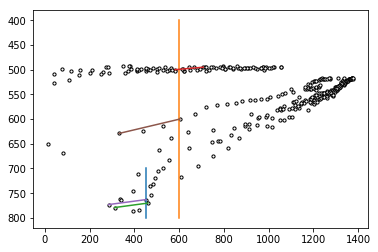

In [0]:
s = 10
plt.gca().invert_yaxis()
#plt.plot(l1X,l1Y)
#plt.plot(l2X,l2Y)
plt.scatter(XY_np[:,0], XY_np[:,1], c='white', s=s, edgecolors='k')
plt.plot(*line2.xy)
plt.plot(*line1.xy)
plt.plot(*vectors[0].xy)
plt.plot(*vectors[1].xy)
plt.plot(*vectors[2].xy)
plt.plot(*vectors[3].xy)

In [0]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3).fit_predict(lanes)
plt.scatter(lanes[:, 0], lanes[:, 1], c=y_pred)

In [0]:
XY

# Lane Finder

In [0]:
XY_np=np.array(XY)

In [0]:
XY_np.shape

(0,)

In [0]:
s = 10
plt.gca().invert_yaxis()
plt.scatter(XY_np[:,0], XY_np[:,1], c='white', s=s, edgecolors='k')

Automatically created module for IPython interactive environment


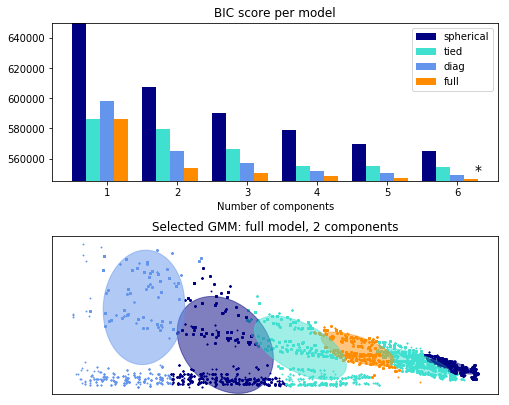

In [0]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
#X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
X = XY_np

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [0]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

In [0]:
X = StandardScaler().fit_transform(XY_np)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
spectral = cluster.SpectralClustering(
        n_clusters=3, eigen_solver='arpack', affinity="nearest_neighbors")
labels=spectral.fit(XY_np).labels_

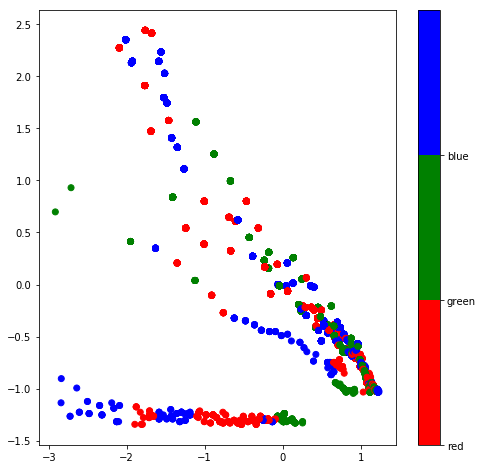

In [0]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels, cmap=mpl.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [0]:
gmm = mixture.GaussianMixture(n_components=3,
                                      covariance_type='full')
labelg=gmm.fit(XY_np)

In [0]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))
plt.scatter(XY_np[:,0], XY_np[:,1], c=labelg, cmap=mpl.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


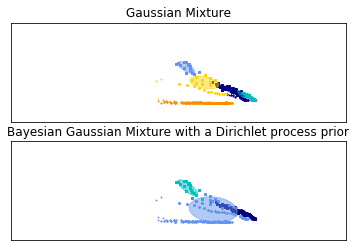

In [0]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
#np.random.seed(0)
#C = np.array([[0., -0.1], [1.7, .4]])
#X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
 #         .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]


# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=3,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

In [0]:
from sklearn.cluster import KMeans

In [0]:
y_pred = KMeans(n_clusters=3).fit_predict(XY_np)

#plt.subplot(221)
plt.scatter(XY_np[:, 0], XY_np[:, 1], c=y_pred)

NameError: ignored

In [0]:
print(__doc__)

# Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
#X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(XY_np)

plt.subplot(221)
plt.scatter(XY_np[:, 0], XY_np[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(XY_np, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((XY_np[y == 0][:500], XY_np[y == 1][:100], XY_np[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=2)
pca.fit(XY_np)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print(pca.components_)

[[-0.98063575  0.19584058]
 [-0.19584058 -0.98063575]]


In [0]:
print(pca.explained_variance_)

[111616.6484905    1784.86034931]


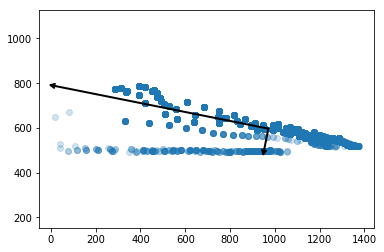

In [0]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(XY_np[:, 0], XY_np[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [0]:
pca.components_

array([[-0.98063575,  0.19584058],
       [-0.19584058, -0.98063575]])

In [0]:
pca.mean_ + v

array([946.64167039, 472.69209143])

In [0]:
dt_transform = np.arctan((XY_np[:,1] - 590) / (XY_np[:,0] - 1400))

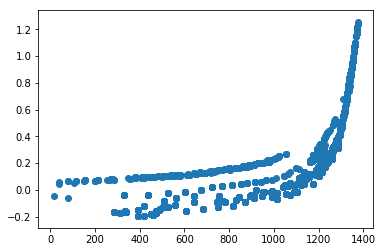

In [0]:
plt.scatter(XY_np[:,0], dt_transform)

In [0]:
dt_transform=dt_transform.reshape(7539,1)
np.hstack((XY_np, dt_transform))

array([[1.16100000e+03, 5.39000000e+02, 2.10235946e-01],
       [7.20000000e+02, 5.02000000e+02, 1.28696501e-01],
       [1.16100000e+03, 5.39000000e+02, 2.10235946e-01],
       ...,
       [1.26300000e+03, 5.18000000e+02, 4.83876063e-01],
       [1.26800000e+03, 5.16000000e+02, 5.10949576e-01],
       [2.82000000e+02, 4.95000000e+02, 8.47695333e-02]])

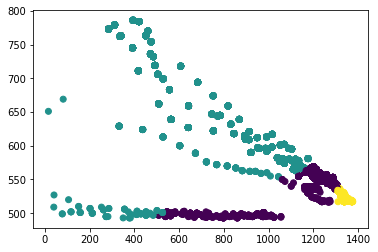

In [0]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3).fit_predict(dt_transform)
plt.scatter(XY_np[:, 0], XY_np[:, 1], c=y_pred)



---


# TPU Stuff


In [0]:
import os
import pprint
import tensorflow as tf
if ‘COLAB_TPU_ADDR’ not in os.environ:
 print(‘ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!’)
else:
 tpu_address = ‘grpc://’ + os.environ[‘COLAB_TPU_ADDR’]
 print (‘TPU address is’, tpu_address)
with tf.Session(tpu_address) as session:
 devices = session.list_devices()
 
 print(‘TPU devices:’)
 pprint.pprint(devices)

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18249090012347905732, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8852923597311812382
 physical_device_desc: "device: XLA_CPU device"]

In [0]:
%ls

# This and that

In [0]:
import pandas as pd
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")

In [0]:
file = 'Vehicles_2016-05-10.csv'
df = pd.read_csv(file)
df['Start'] = pd.to_datetime(df["Start-Timestamp"])
df['End'] = pd.to_datetime(df["End-Timestamp"])
starttime = pd.to_datetime('10.05.2016 11:53:16')
df_new = df[df['Start'] >= starttime] 
df_new.reset_index(inplace=True)
pd.Timedelta(df_new['Start'][2]-starttime).seconds

In [0]:
for i in range(10):
    print(pd.Timedelta(df_new['Start'][i]-starttime).seconds)

# Sonstiges

In [0]:
starttime

Timestamp('2016-10-05 11:53:16')

In [0]:
df_new['Start'].head()

1694   2016-10-05 11:53:16
1695   2016-10-05 11:53:19
1696   2016-10-05 11:53:21
1697   2016-10-05 11:53:23
1698   2016-10-05 11:53:26
Name: Start, dtype: datetime64[ns]

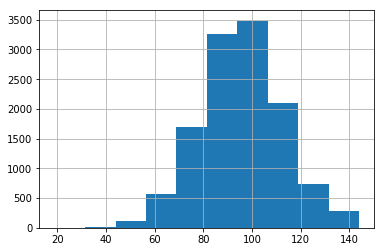

In [0]:
df_new['Speed'].hist()

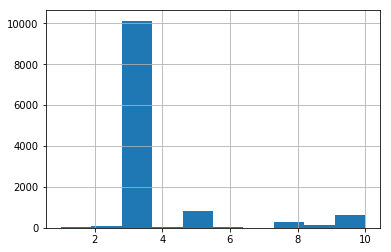

In [0]:
df_new['ExtCatNo'].hist()

In [0]:
df_new['CatNo'].describe()

In [0]:
df_new['ExtCatNo'].value_counts()

3     10126
5       845
10      632
8       293
9       150
2        76
4        50
6        49
1        37
7         4
Name: ExtCatNo, dtype: int64

In [0]:
df_new2 = df_new[df_new['ExtCatNo'] == 7]

In [0]:
df_new2

,index,Start-Timestamp,Ms,End-Timestamp,Ms.1,Dur,Road,Lane,Speed,Width,Height,Length,CatNo,CatText,ExtCatNo,ExtCatText,Start,End
4072,5766,10.05.2016 14:25:05,100,10.05.2016 14:25:05,637,536,0,0,88.90,2091,3575,11482,611,ArticVan,7,VanArtic,2016-10-05 14:25:05,2016-10-05 14:25:05
7076,8770,10.05.2016 15:57:10,660,10.05.2016 15:57:11,174,514,0,0,91.76,2119,3599,11402,611,ArticVan,7,VanArtic,2016-10-05 15:57:10,2016-10-05 15:57:11
9257,10951,10.05.2016 17:22:22,656,10.05.2016 17:22:23,167,511,0,0,84.60,2186,3595,10819,611,ArticVan,7,VanArtic,2016-10-05 17:22:22,2016-10-05 17:22:23
10489,12183,10.05.2016 18:54:56,745,10.05.2016 18:54:57,181,436,0,0,97.86,2211,3765,9926,611,ArticVan,7,VanArtic,2016-10-05 18:54:56,2016-10-05 18:54:57


In [0]:
df_new.head()

,index,Start-Timestamp,Ms,End-Timestamp,Ms.1,Dur,Road,Lane,Speed,Width,Height,Length,CatNo,CatText,ExtCatNo,ExtCatText,Start,End
0,1694,10.05.2016 11:53:16,493,10.05.2016 11:53:16,960,466,0,0,88.69,2483,3396,9717,440,TruckLowLoaded,8,Truck,2016-10-05 11:53:16,2016-10-05 11:53:16
1,1695,10.05.2016 11:53:19,454,10.05.2016 11:53:19,936,481,0,0,84.40,2253,3513,10099,440,TruckLowLoaded,8,Truck,2016-10-05 11:53:19,2016-10-05 11:53:19
2,1696,10.05.2016 11:53:21,615,10.05.2016 11:53:22,52,436,0,0,78.80,2399,4098,9139,410,Truck,8,Truck,2016-10-05 11:53:21,2016-10-05 11:53:22
3,1697,10.05.2016 11:53:23,286,10.05.2016 11:53:23,437,150,0,1,111.20,1308,1526,3396,210,Car,3,Car,2016-10-05 11:53:23,2016-10-05 11:53:23
4,1698,10.05.2016 11:53:26,718,10.05.2016 11:53:26,876,157,0,1,115.19,1056,1731,3600,210,Car,3,Car,2016-10-05 11:53:26,2016-10-05 11:53:26


In [0]:
testerdf=df_new

In [0]:
testerdf['Start'][1]

Timestamp('2016-10-05 11:53:19')

In [0]:
testerdf.head()

,index,Start-Timestamp,Ms,End-Timestamp,Ms.1,Dur,Road,Lane,Speed,Width,Height,Length,CatNo,CatText,ExtCatNo,ExtCatText,Start,End
0,1694,10.05.2016 11:53:16,493,10.05.2016 11:53:16,960,466,0,0,88.69,2483,3396,9717,440,TruckLowLoaded,8,Truck,2016-10-05 11:53:16,2016-10-05 11:53:16
1,1695,10.05.2016 11:53:19,454,10.05.2016 11:53:19,936,481,0,0,84.40,2253,3513,10099,440,TruckLowLoaded,8,Truck,2016-10-05 11:53:19,2016-10-05 11:53:19
2,1696,10.05.2016 11:53:21,615,10.05.2016 11:53:22,52,436,0,0,78.80,2399,4098,9139,410,Truck,8,Truck,2016-10-05 11:53:21,2016-10-05 11:53:22
3,1697,10.05.2016 11:53:23,286,10.05.2016 11:53:23,437,150,0,1,111.20,1308,1526,3396,210,Car,3,Car,2016-10-05 11:53:23,2016-10-05 11:53:23
4,1698,10.05.2016 11:53:26,718,10.05.2016 11:53:26,876,157,0,1,115.19,1056,1731,3600,210,Car,3,Car,2016-10-05 11:53:26,2016-10-05 11:53:26


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13956 entries, 0 to 13955
Data columns (total 16 columns):
Start-Timestamp    13956 non-null object
Ms                 13956 non-null int64
End-Timestamp      13956 non-null object
Ms.1               13956 non-null int64
Dur                13956 non-null int64
Road               13956 non-null int64
Lane               13956 non-null int64
Speed              13956 non-null float64
Width              13956 non-null int64
Height             13956 non-null int64
Length             13956 non-null int64
CatNo              13956 non-null int64
CatText            13956 non-null object
ExtCatNo           13956 non-null int64
ExtCatText         13956 non-null object
0                  13956 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(10), object(4)
memory usage: 1.7+ MB


In [0]:
df.describe()

,Ms,Ms.1,Dur,Road,Lane,Speed,Width,Height,Length,CatNo,ExtCatNo
count,13956.000000,13956.000000,13956.000000,13956.0,13956.000000,13956.000000,13956.000000,13956.000000,13956.000000,13956.000000,13956.000000
mean,497.059974,497.898108,215.158570,0.0,0.393451,95.148575,1373.349169,1885.244411,4514.126612,243.288048,3.731585
std,289.189667,288.227659,163.377765,0.0,0.488533,17.336976,406.218536,745.186521,3396.665695,85.523484,1.884720
min,0.000000,0.000000,-562.000000,0.0,0.000000,8.380000,59.000000,929.000000,1766.000000,110.000000,1.000000
25%,244.000000,252.000000,145.000000,0.0,0.000000,83.930000,1186.000000,1518.000000,3232.000000,210.000000,3.000000
50%,496.000000,495.000000,163.000000,0.0,0.000000,95.070000,1334.000000,1592.500000,3400.000000,210.000000,3.000000
75%,745.000000,749.000000,190.000000,0.0,1.000000,106.230000,1458.000000,1793.000000,3942.000000,210.000000,3.000000
max,999.000000,999.000000,1598.000000,0.0,1.000000,144.000000,2779.000000,4298.000000,20859.000000,611.000000,10.000000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13956 entries, 0 to 13955
Data columns (total 17 columns):
Start-Timestamp    13956 non-null object
Ms                 13956 non-null int64
End-Timestamp      13956 non-null object
Ms.1               13956 non-null int64
Dur                13956 non-null int64
Road               13956 non-null int64
Lane               13956 non-null int64
Speed              13956 non-null float64
Width              13956 non-null int64
Height             13956 non-null int64
Length             13956 non-null int64
CatNo              13956 non-null int64
CatText            13956 non-null object
ExtCatNo           13956 non-null int64
ExtCatText         13956 non-null object
Start              13956 non-null datetime64[ns]
End                13956 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(10), object(4)
memory usage: 1.8+ MB


In [0]:
dati[1]

Timestamp('2016-10-05 10:40:15')

In [0]:
df.head()

,Start-Timestamp,Ms,End-Timestamp,Ms.1,Dur,Road,Lane,Speed,Width,Height,Length,CatNo,CatText,ExtCatNo,ExtCatText,Start,End
0,10.05.2016 10:40:12,555,10.05.2016 10:40:12,685,129,0,1,130.37,972,1725,3277,210,Car,3,Car,2016-10-05 10:40:12,2016-10-05 10:40:12
1,10.05.2016 10:40:15,267,10.05.2016 10:40:16,90,823,0,0,91.93,2063,4103,18875,411,TruckWithTrailer,9,TruckWithTrailer,2016-10-05 10:40:15,2016-10-05 10:40:16
2,10.05.2016 10:40:16,406,10.05.2016 10:40:16,607,200,0,1,125.07,1249,2484,5195,310,Van,5,Van,2016-10-05 10:40:16,2016-10-05 10:40:16
3,10.05.2016 10:40:17,660,10.05.2016 10:40:18,442,781,0,0,87.44,2132,4110,18927,510,ArticTruck,10,TruckArtic,2016-10-05 10:40:17,2016-10-05 10:40:18
4,10.05.2016 10:40:18,464,10.05.2016 10:40:18,609,144,0,1,89.48,1032,1593,2625,210,Car,3,Car,2016-10-05 10:40:18,2016-10-05 10:40:18


In [0]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12262 entries, 1694 to 13955
Data columns (total 17 columns):
Start-Timestamp    12262 non-null object
Ms                 12262 non-null int64
End-Timestamp      12262 non-null object
Ms.1               12262 non-null int64
Dur                12262 non-null int64
Road               12262 non-null int64
Lane               12262 non-null int64
Speed              12262 non-null float64
Width              12262 non-null int64
Height             12262 non-null int64
Length             12262 non-null int64
CatNo              12262 non-null int64
CatText            12262 non-null object
ExtCatNo           12262 non-null int64
ExtCatText         12262 non-null object
Start              12262 non-null datetime64[ns]
End                12262 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(10), object(4)
memory usage: 1.7+ MB
